___

#### Rick Fontenot, Joe Lazarus, Puri Rudick
####
___


## This first section is a copy of the tensorflow tutorial to confirm setup, reference:
https://www.tensorflow.org/tutorials/keras/classification

Load the Tensorflow Library

In [142]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

#np.random.seed(123)
#tf.random.set_seed(42)

2.8.0


In [143]:
# Set a seed value
seed_value= 12321 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

#6 Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

Import the Fashion MNIST dataset

In [144]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [145]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [146]:
train_images.shape


(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [147]:
len(train_labels)


60000

Each label is an integer between 0 and 9:

In [148]:
train_labels


array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [149]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [150]:
len(test_labels)

10000

## Preprocess the data
The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

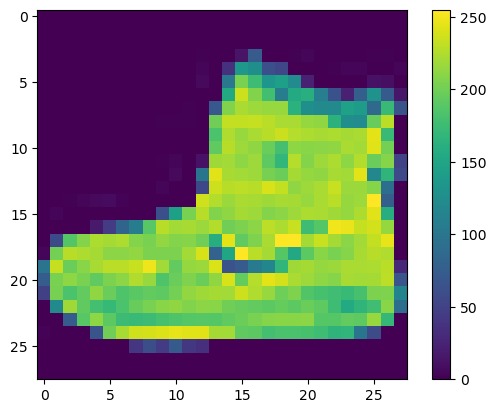

In [151]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [152]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

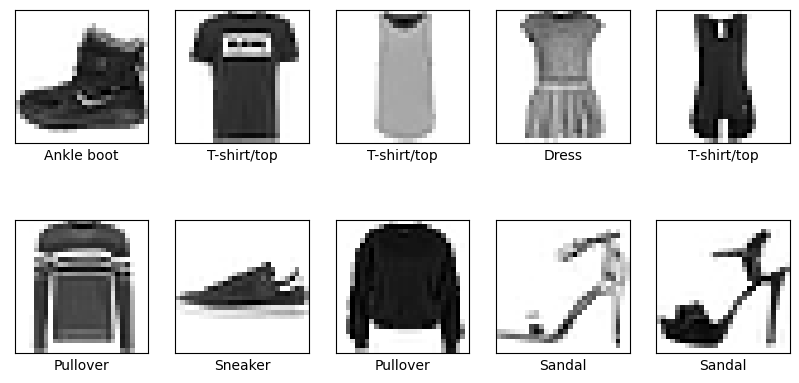

In [153]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Add Hierarchical class labels to the training and test sets 

In [154]:
import pandas as pd

train100_labels = pd.DataFrame(train_labels)
train100_labels = train100_labels.rename(columns={train100_labels.columns[0]: 'label'})

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               
d = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

train100_labels['fine_label'] = replace_all(train100_labels['label'], d)

train100_labels.head(20)

,label,fine_label
0,9,Ankle boot
1,0,T-shirt/top
2,0,T-shirt/top
3,3,Dress
4,0,T-shirt/top
5,2,Pullover
6,7,Sneaker
7,2,Pullover
8,5,Sandal
9,5,Sandal


In [155]:
medium_dictionary = {'T-shirt/top': 'Tops', 'Trouser': 'Bottoms', 'Pullover': 'Tops', 'Dress': 'Dresses', 'Coat': 'Outers', 'Sandal': 'Shoes', 'Shirt': 'Tops', 'Sneaker': 'Shoes', 'Bag': 'Accessories', 'Ankle boot': 'Shoes'}
train100_labels['medium_label']= train100_labels['fine_label'].map(medium_dictionary)

coarse_dictionary = {'Tops': 'Clothes', 'Bottoms': 'Clothes', 'Dresses': 'Clothes', 'Outers': 'Clothes', 'Shoes': 'Goods', 'Accessories': 'Goods'}
train100_labels['coarse_label']= train100_labels['medium_label'].map(coarse_dictionary)

train100_images_flattened = pd.DataFrame(train_images.flatten().reshape(60000, 784))

train100 = pd.concat([train100_labels, train100_images_flattened], axis=1)

train100.head()

,label,fine_label,medium_label,coarse_label,0,1,2,3,4,5,...,774,775,776,777,778,779,780,781,782,783
0,9,Ankle boot,Shoes,Goods,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,T-shirt/top,Tops,Clothes,0.0,0.0,0.0,0.0,0.0,0.003922,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0,T-shirt/top,Tops,Clothes,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Dress,Dresses,Clothes,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0,T-shirt/top,Tops,Clothes,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
import pandas as pd

test_labels = pd.DataFrame(test_labels)
test_labels = test_labels.rename(columns={test_labels.columns[0]: 'label'})

test_labels['fine_label'] = replace_all(test_labels['label'], d)
test_labels['medium_label']= test_labels['fine_label'].map(medium_dictionary)
test_labels['coarse_label']= test_labels['medium_label'].map(coarse_dictionary)

test_images_flattened = pd.DataFrame(test_images.flatten().reshape(10000, 784))

test = pd.concat([test_labels, test_images_flattened], axis=1)

test.head(20)

,label,fine_label,medium_label,coarse_label,0,1,2,3,4,5,...,774,775,776,777,778,779,780,781,782,783
0,9,Ankle boot,Shoes,Goods,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2,Pullover,Tops,Clothes,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.007843,0.011765,0.000000,0.011765,0.682353,0.741176,0.262745,0.000000,0.0,0.0
2,1,Trouser,Bottoms,Clothes,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.643137,0.227451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,1,Trouser,Bottoms,Clothes,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,6,Shirt,Tops,Clothes,0.0,0.0,0.0,0.007843,0.0,0.003922,...,0.278431,0.047059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5,1,Trouser,Bottoms,Clothes,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.568627,0.505882,0.243137,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
6,4,Coat,Outers,Clothes,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.141176,0.117647,0.105882,0.105882,0.000000,0.000000,0.0,0.0
7,6,Shirt,Tops,Clothes,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.039216,0.000000,0.000000,0.137255,0.329412,0.215686,0.000000,0.000000,0.0,0.0
8,5,Sandal,Shoes,Goods,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
9,7,Sneaker,Shoes,Goods,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


## Stratified split of training set into 90% train, 10% validation
### Validation can be used for early stopping on models 3,4,5
### and for tuning on model 5
### Once stopping criteria and hyperparameters determined, re-fit with full training set before predictions

In [157]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, holdback_index in split.split(train100, train100.label):
    train90 = train100.iloc[train_index]
    validation10 = train100.iloc[holdback_index]


In [158]:
print("90% Training set \n",train90['fine_label'].value_counts())
print("10% Validation set \n",validation10['fine_label'].value_counts())



90% Training set 
 Bag            5400
Ankle boot     5400
T-shirt/top    5400
Trouser        5400
Coat           5400
Shirt          5400
Sandal         5400
Sneaker        5400
Dress          5400
Pullover       5400
Name: fine_label, dtype: int64
10% Validation set 
 Dress          600
Trouser        600
Ankle boot     600
Bag            600
Pullover       600
Coat           600
T-shirt/top    600
Shirt          600
Sandal         600
Sneaker        600
Name: fine_label, dtype: int64


In [159]:
train90_images_flattened = train90.iloc[:,4:784].values
validation10_images_flattened = validation10.iloc[:,4:784].values


Based on framework described above, the following training subsets need to be created:

train100_clothes --> subset train100.coarse_label == "Clothes" should have 36,000 rows
train100_goods --> subset train100.coarse_label == "Goods" should have 24,000 rows
train100_tops --> subset train100.medium_label == "Tops" should have 18,000 rows
train100_shoes --> subset train100.medium_label == "Shoes" should have 18,000 rows

** Note the 1st coarse model just uses the full training set, no subset needed

In [160]:
train100_clothes = train100[train100.coarse_label == "Clothes"]
print("Clothes # Rows = ",train100_clothes.shape[0])
train100_goods = train100[train100.coarse_label == "Goods"]
print("Goods # Rows = ",train100_goods.shape[0])
train100_tops = train100[train100.medium_label == "Tops"]
print("Tops # Rows = ",train100_tops.shape[0])
train100_shoes = train100[train100.medium_label == "Shoes"]
print("Shoes # Rows = ",train100_shoes.shape[0])

Clothes # Rows =  36000
Goods # Rows =  24000
Tops # Rows =  18000
Shoes # Rows =  18000


Create "X" with just the flattened image columns for each training set

In [161]:
train100_clothes_flattened = train100_clothes.iloc[:,4:784].values
train100_goods_flattened = train100_goods.iloc[:,4:784].values
train100_tops_flattened = train100_tops.iloc[:,4:784].values
train100_shoes_flattened = train100_shoes.iloc[:,4:784].values



## Model 3: Flat NN with early stopping for epochs

Define early stopping criteria using validation set for monitoring

In [162]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=3,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


In [163]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [164]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [165]:
from tensorflow.keras.callbacks import TensorBoard
from time import time
tb = TensorBoard(log_dir=f"logs\\{time()}")

In [166]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [167]:
from datetime import datetime

model3_start_time = datetime.now()
model3.fit(train100_images_flattened, np.asarray(train100.label), validation_split=0.1, epochs=200, callbacks=[earlystop, tb])
model3_end_time = datetime.now()
model3_train_time = model3_end_time - model3_start_time
print("Model 3 Training Time = ",model3_train_time)

Epoch 1/200
1688/1688 [==============================] - 8s 5ms/step - loss: 0.5133 - accuracy: 0.8213 - val_loss: 0.4476 - val_accuracy: 0.8383
Epoch 2/200
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3790 - accuracy: 0.8638 - val_loss: 0.3690 - val_accuracy: 0.8692
Epoch 3/200
1688/1688 [==============================] - 8s 4ms/step - loss: 0.3393 - accuracy: 0.8750 - val_loss: 0.3490 - val_accuracy: 0.8705
Epoch 4/200
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3164 - accuracy: 0.8845 - val_loss: 0.3319 - val_accuracy: 0.8793
Epoch 5/200
1688/1688 [==============================] - 8s 4ms/step - loss: 0.2968 - accuracy: 0.8918 - val_loss: 0.3296 - val_accuracy: 0.8805
Epoch 6/200
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2826 - accuracy: 0.8958 - val_loss: 0.3301 - val_accuracy: 0.8792
Epoch 7/200
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2700 - accuracy: 0.9004 - val_loss: 0.3226 - val_ac

In [168]:
model3_probbabilities = tf.keras.Sequential([model3, tf.keras.layers.Softmax()])
model3_predictions = model3_probbabilities.predict(test_images_flattened)
model3_prediction_label = np.argmax(model3_predictions, axis=1)

In [169]:
import pandas as pd

model3_prediction_labels = pd.DataFrame(model3_prediction_label)
model3_prediction_labels = model3_prediction_labels.rename(columns={model3_prediction_labels.columns[0]: 'label'})

model3_prediction_labels['fine_prediction'] = replace_all(model3_prediction_labels['label'], d)
model3_prediction_labels['medium_prediction']= model3_prediction_labels['fine_prediction'].map(medium_dictionary)
model3_prediction_labels['coarse_prediction']= model3_prediction_labels['medium_prediction'].map(coarse_dictionary)

model3_prediction_labels.head(10)

,label,fine_prediction,medium_prediction,coarse_prediction
0,9,Ankle boot,Shoes,Goods
1,2,Pullover,Tops,Clothes
2,1,Trouser,Bottoms,Clothes
3,1,Trouser,Bottoms,Clothes
4,6,Shirt,Tops,Clothes
5,1,Trouser,Bottoms,Clothes
6,4,Coat,Outers,Clothes
7,6,Shirt,Tops,Clothes
8,5,Sandal,Shoes,Goods
9,7,Sneaker,Shoes,Goods


In [170]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

model3_fine_accuracy = accuracy_score(test_labels.fine_label, model3_prediction_labels.fine_prediction)
model3_medium_accuracy = accuracy_score(test_labels.medium_label, model3_prediction_labels.medium_prediction)
model3_coarse_accuracy = accuracy_score(test_labels.coarse_label, model3_prediction_labels.coarse_prediction)

print("Fine Level Accuracy = ",model3_fine_accuracy)
print("Medium Level Accuracy = ",model3_medium_accuracy)
print("Coarse Level Accuracy = ",model3_coarse_accuracy)
print("\n")
print("Fine Level Classification Report \n",classification_report(test_labels.fine_label,model3_prediction_labels.fine_prediction, 
                            target_names=class_names))

Fine Level Accuracy =  0.8807
Medium Level Accuracy =  0.9343
Coarse Level Accuracy =  0.9948


Fine Level Classification Report 
               precision    recall  f1-score   support

 T-shirt/top       0.97      0.95      0.96      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.73      0.87      0.79      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.79      0.77      0.78      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.73      0.62      0.67      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.83      0.86      0.84      1000
  Ankle boot       0.99      0.97      0.98      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [171]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print("Fine Level Accuracy = ", accuracy_score(test_labels.fine_label, model3_prediction_labels.fine_prediction))
fine_classification_report = classification_report(test_labels.fine_label,model3_prediction_labels.fine_prediction, target_names=class_names)
print(fine_classification_report)
# Print to the text file
file = open('fine_classification.txt', 'w')
print("Total Training Time All levels=",model3_train_time.total_seconds(), file = file)
print("Fine Level Accuracy = ", accuracy_score(test_labels.fine_label, model3_prediction_labels.fine_prediction), file = file)
print(fine_classification_report, file = file)
file.close()


Fine Level Accuracy =  0.8807
              precision    recall  f1-score   support

 T-shirt/top       0.97      0.95      0.96      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.73      0.87      0.79      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.79      0.77      0.78      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.73      0.62      0.67      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.83      0.86      0.84      1000
  Ankle boot       0.99      0.97      0.98      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [172]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print("Medium Level Accuracy = ", accuracy_score(test_labels.medium_label, model3_prediction_labels.medium_prediction))
medium_classification_report = (classification_report(test_labels.medium_label, model3_prediction_labels.medium_prediction))
print(fine_classification_report)
# Print to the text file
file = open('medium_classification.txt', 'w')
print("Total Training Time All levels=",model3_train_time.total_seconds(), file = file)
print("Medium Level Accuracy = ", accuracy_score(test_labels.medium_label, model3_prediction_labels.medium_prediction), file = file)
print(medium_classification_report, file = file)
file.close()


Medium Level Accuracy =  0.9343
              precision    recall  f1-score   support

 T-shirt/top       0.97      0.95      0.96      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.73      0.87      0.79      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.79      0.77      0.78      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.73      0.62      0.67      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.83      0.86      0.84      1000
  Ankle boot       0.99      0.97      0.98      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [173]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print("Coarse Level Accuracy = ", accuracy_score(test_labels.coarse_label, model3_prediction_labels.coarse_prediction))
coarse_classification_report = (classification_report(test_labels.coarse_label, model3_prediction_labels.coarse_prediction))
print(coarse_classification_report)
# Print to the text file
file = open('coarse_classification.txt', 'w')
print("Total Training Time All levels=",model3_train_time.total_seconds(), file = file)
print("Coarse Level Accuracy = ", accuracy_score(test_labels.coarse_label, model3_prediction_labels.coarse_prediction), file = file)
print(coarse_classification_report, file = file)
file.close()

Coarse Level Accuracy =  0.9948
              precision    recall  f1-score   support

     Clothes       0.99      1.00      1.00      6000
       Goods       1.00      0.99      0.99      4000

    accuracy                           0.99     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

